In [140]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 
from scipy.optimize import curve_fit



In [141]:
# import sys
# sys.path.append('/home/pkruyt/cernbox/CERN-coolers/LEIR/ions')

# from ion_properties import ions, IonProperties

In [142]:
# context = xo.ContextCpu(omp_num_threads=4)
context = xo.ContextCpu()

line = xt.Line.from_json('sps.json')
particle_ref0=line.particle_ref
line.build_tracker()

clight=constants.speed_of_light
circumference = line.get_length()
twiss=line.twiss()
#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['bets0']
voltage_rf=7*1e6
frequency=201.8251348335775*1e6
lag_rf=180
momentum_compaction_factor=twiss['momentum_compaction_factor']
slip_factor=['slip_factor']

# qs=0.0131
# bets=0.063/2e-4

#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101

Dx  =  2.444732 # m
Dpx =  0.097522


Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        # qs=qs,
        # bets=bets,
        voltage_rf=voltage_rf,
        lag_rf=lag_rf,
        frequency_rf=frequency,
        momentum_compaction_factor=momentum_compaction_factor,
        longitudinal_mode = 'nonlinear',

        )

Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [143]:
from ion_properties import lead,calcium,xenon,xenon2nd


In [144]:
# injection_nemitt = 1.5*1e-6 # m*rad (normalized emittance)
# injection_dp_p = 2e-4
# sigma_z = 0.063 #https://cds.cern.ch/record/2690736/files/SPSC-I-253.pdf


Loop over both sig_delta and emittance

In [145]:
sig_delta_list = np.linspace(2e-5, 2.2e-4, 2)
sig_delta_list = np.linspace(1.8e-4, 2.2e-4, 1)
n_emitt_list=np.linspace(1e-7,1.7e-6,50)

# sig_delta_list = np.linspace(0.4e-4, 1e-4, 10)
# n_emitt_list=np.linspace(0.5e-6,1.5e-6,10)


transverse_cooling_rate_array = np.zeros((len(sig_delta_list), len(n_emitt_list)))
longitudinal_growth_rate_array = np.zeros((len(sig_delta_list), len(n_emitt_list)))

for ion_loop in [lead]:
        # Ion properties:
        q0 = ion_loop.q0
        mass0 = ion_loop.mass0

        gamma = ion_loop.gamma_cooling
        beta=  np.sqrt(1-1/(gamma*gamma))
        p0c = mass0*gamma*beta #eV/c

        bunch_intensity = ion_loop.bunch_intensity

        particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0,gamma0=gamma)

        line.particle_ref=particle_ref


        #nemitt = 1.5e-6 # m*rad (normalized emittance)
        sigma_z = ion_loop.bunch_length #m

        final_dp_p = 0.0001728839510532224
        final_sigma_z = 0.05471725110721688
        final_emittance_x = 5.39358862649646e-07
        final_emittance_y = 7.282517077715001e-07
        #halfway
        final_dp_p= 2e-4  
        final_sigma_z= sigma_z
        final_emittance_x= 1.5e-6
        final_emittance_y= 1.5e-6

        num_particles=int(1e3)

        line_arc=xt.Line(
                elements=[arc])
        line_arc.build_tracker()
        
            
        particles = xp.generate_matched_gaussian_bunch(
                num_particles=num_particles,
                total_intensity_particles=bunch_intensity,
                nemitt_x=final_emittance_x, nemitt_y=final_emittance_y, sigma_z=final_sigma_z,
                particle_ref=particle_ref,
                line=line_arc,        
                )
        
        particles._init_random_number_generator()

        particles0=particles.copy()
        # sigma_dp=2e-4  
        sigma_dp=np.std(particles.delta)
        print(sigma_dp)
        sigma_dp=2e-4  
        
        ##################
        # Laser Cooler #
        ##################

        #laser-ion beam collision angle
        theta_l = 2.6*np.pi/180 # rad
        nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

        # Ion excitation energy:
        ion_excited_lifetime=ion_loop.excited_lifetime
        hw0 = ion_loop.hw0 # eV
        hc=constants.hbar*clight/constants.e # eV*m (ħc)
        lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

        lambda_l = ion_loop.lambda_l

        # # Shift laser wavelength for fast longitudinal cooling:5
        # lambda_l = lambda_l*(1+1*sigma_dp) # m

        laser_frequency = clight/lambda_l # Hz
        sigma_w = 2*np.pi*laser_frequency*sigma_dp
        #sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

        sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
        print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
        print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

        laser_waist_radius = 1.3e-3 #m
        laser_energy = 5e-3
        laser_x = ion_loop.laser_x
        
        GF_IP = xt.PulsedLaser(
                        laser_x=laser_x,
                        laser_y=0,
                        laser_z=0,
                        
                        laser_direction_nx = 0,
                        laser_direction_ny = ny,
                        laser_direction_nz = nz,
                        laser_energy         = laser_energy, # J
                        laser_duration_sigma = sigma_t, # sec
                        laser_wavelength = lambda_l, # m
                        laser_waist_radius = laser_waist_radius, # m
                        laser_waist_shift = 0, # m
                        ion_excitation_energy = hw0, # eV
                        ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                        )

        # simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
        max_time_s = 1
        int_time_s = 0.01
        T_per_turn = circumference/(clight*beta)
        num_turns = int(max_time_s/T_per_turn)
        save_interval = int(int_time_s/T_per_turn)

        # num_turns = int(1e3)
        # save_interval = num_turns/100
        # # save_interval=1

        # create a monitor object, to reduce holded data
        monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                n_repetitions=int(num_turns/save_interval),
                                repetition_period=save_interval,
                                num_particles=num_particles)


        # line.discard_tracker()
        # IP_index=16675   
        # line.insert_element('monitor', element=monitor, index=IP_index)
        # line.insert_element('GF_IP', element=GF_IP, index=IP_index) #this way monitor comes after the laser
        # SPS_line.append_element(monitor,'monitor')
        # SPS_line.append_element(GF_IP,'GF_IP')
                        
        particles=particles0.copy()

        line = xt.Line(
                elements=[monitor,GF_IP,arc])

        context = xo.ContextCpu(omp_num_threads=1)
        line.build_tracker(_context=context)
        # line.optimize_for_tracking()

        line.track(particles, num_turns=num_turns,
                turn_by_turn_monitor=False,with_progress=False)

        # extract relevant values
        x = monitor.x[:,:,0]
        px = monitor.px[:,:,0]
        y = monitor.y[:,:,0]
        py = monitor.py[:,:,0]
        delta = monitor.delta[:,:,0]
        zeta = monitor.zeta[:,:,0]
        state = monitor.state[:,:,0]
        time = monitor.at_turn[:, 0, 0] * T_per_turn

        gamma_x=(1+alpha_x**2)/beta_x
        gamma_y=(1+alpha_y**2)/beta_y

        action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
        action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

        emittance_x=np.mean(action_x,axis=1)*gamma/2

        # Define the exponential function
        def exponential_func(x, a, b):
                return a * np.exp(x * b)
        
        # Fit the data to the exponential function
        params_transverse, covariance = curve_fit(exponential_func, time, emittance_x)

        # Extract the parameters
        a, b = params_transverse

        transverse_cooling_rate=b       

        # plt.plot(time,emittance_x*1e6, linewidth=5.0)
        # plt.plot(time, exponential_func(time,
        # *params_transverse) * 1e6, linestyle='--')
        
        # Fit the data to the exponential function
        rms_dp_p = np.std(delta, axis=1)
        window_size = 10  # or any other suitable value
        rms_dp_p_smoothed = np.convolve(rms_dp_p, np.ones(window_size)/window_size, mode='valid')


        params_longitudinal, covariance = curve_fit(exponential_func, time[:len(rms_dp_p_smoothed)], rms_dp_p_smoothed)

        # Extract the parameters
        a, b = params_longitudinal

        longitudinal_growth_rate=b

        # Calculate mean and standard deviation along the particle axis (axis=1)
        mean_z = np.mean(zeta, axis=1)
        mean_delta = np.mean(delta, axis=1)
        sigma_z = np.std(zeta, axis=1)
        sigma_delta = np.std(delta, axis=1)

        # Calculate the covariance between zeta and delta for each turn
        cov_z_delta = np.mean(zeta * delta, axis=1) - mean_z * mean_delta

        # Calculate longitudinal emittance for each turn
        longitudinal_emittance = np.sqrt(sigma_z**2 * sigma_delta**2 - cov_z_delta**2)

        params_longitudinal_emittance, covariance = curve_fit(exponential_func, time, longitudinal_emittance)

        # Extract the parameters
        a, b = params_longitudinal_emittance

        longitudinal_emittance_growth_rate=b


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
*** Maximum RMS bunch length 0.23410655471212105m.
... distance to target bunch length: -6.3000e-02
... distance to target bunch length: 1.6464e-01
... distance to target bunch length: 7.8245e-02
... distance to target bunch length: -3.7042e-03
... distance to target bunch length: -7.4446e-05
... distance to target bunch length: -1.7696e-08
... distance to target bunch length: 3.0957e-07
--> Bunch length: 0.06299998230379811
--> Emittance: 0.12255478343691063
0.00019464826215934757
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


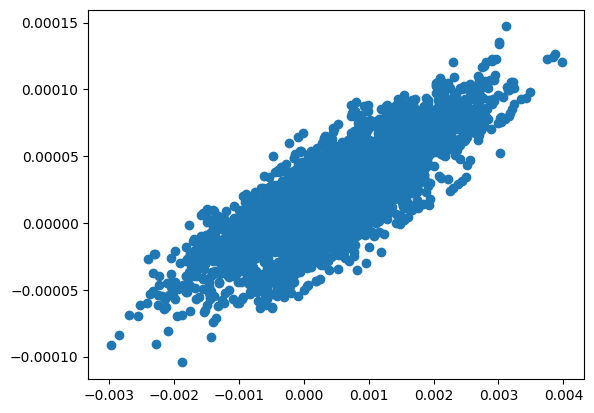

In [146]:
plt.figure()
plt.scatter(x[state==2],px[state==2])
plt.show()

-0.009643689817605505
-0.010160744968303981
-0.010305325500829061
-0.010042424131763207
-0.010240794569340938
-0.010207344708092253
-0.0102287295067815
-0.01052178863817294
-0.01067084914545309
-0.01301045139587643


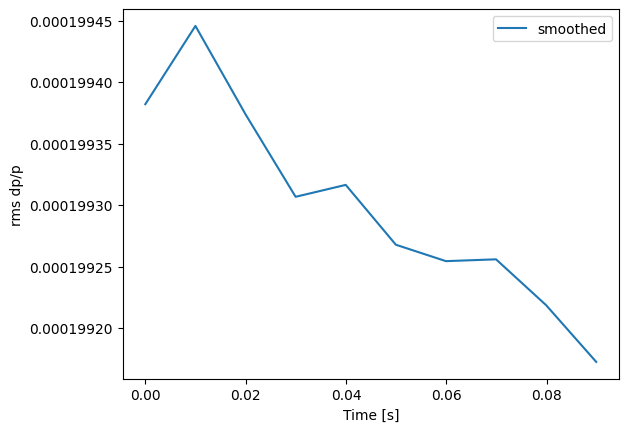

In [147]:
for window_size in range(1,100,10):

    # window_size=30
    rms_dp_p_smoothed = np.convolve(rms_dp_p, np.ones(window_size)/window_size, mode='valid')

    params_longitudinal, covariance = curve_fit(exponential_func, time[:len(rms_dp_p_smoothed)], rms_dp_p_smoothed)

    # Extract the parameters
    a, b = params_longitudinal

    longitudinal_growth_rate=b

    print(longitudinal_growth_rate)


plt.figure()
#plt.plot(time,rms_dp_p,label='raw')
plt.plot(time[:len(rms_dp_p_smoothed)],rms_dp_p_smoothed,label='smoothed')
plt.xlabel('Time [s]')
plt.ylabel('rms dp/p')
plt.legend()
plt.show()

In [148]:
print('longitudinal_growth_rate =', longitudinal_growth_rate)
print('longitudinal_emittance_growth_rate =', longitudinal_emittance_growth_rate)
print('transverse_cooling_rate =', transverse_cooling_rate)

longitudinal_growth_rate = -0.01301045139587643
longitudinal_emittance_growth_rate = -0.02008203789281282
transverse_cooling_rate = -0.012514590058644607


In [149]:
# Find the indices closest to the injection values
for i,ion_loop in tqdm(enumerate([lead])):

    data = np.load(f'results/IBS_bunched/{ion_loop.name}.npz')

    growth_rates_2d_x = data['growth_rates_2d_x']
    growth_rates_2d_y = data['growth_rates_2d_y']
    growth_rates_2d_z = 0.5*data['growth_rates_2d_z']

    sig_delta_list = data['sig_delta_list']
    n_emitt_list = data['n_emitt_list']

    emittance_idx = (np.abs(n_emitt_list - final_emittance_x)).argmin()
    dp_p_idx = (np.abs(sig_delta_list - final_dp_p)).argmin()

# Extract the growth rates at the specified injection point
growth_rate_x = growth_rates_2d_x[emittance_idx, dp_p_idx]
growth_rate_y = growth_rates_2d_y[emittance_idx, dp_p_idx]
growth_rate_z = growth_rates_2d_z[emittance_idx, dp_p_idx]

# Print the growth rates at the injection point
print(f"Growth rates at final point (emittance: {final_emittance_x}, dp/p: {final_dp_p}):")
print(f"Horizontal growth rate: {growth_rate_x}")
print(f"Vertical growth rate: {growth_rate_y}")
print(f"Longitudinal growth rate: {growth_rate_z}")

1it [00:00, 494.44it/s]

Growth rates at final point (emittance: 1.5e-06, dp/p: 0.0002):
Horizontal growth rate: 0.0007957727630147432
Vertical growth rate: -1.6124361728078772e-05
Longitudinal growth rate: 0.0014543290748979894


In [150]:
final_sigma_z

0.063

In [151]:
transverse_cooling_rate


-0.012514590058644607

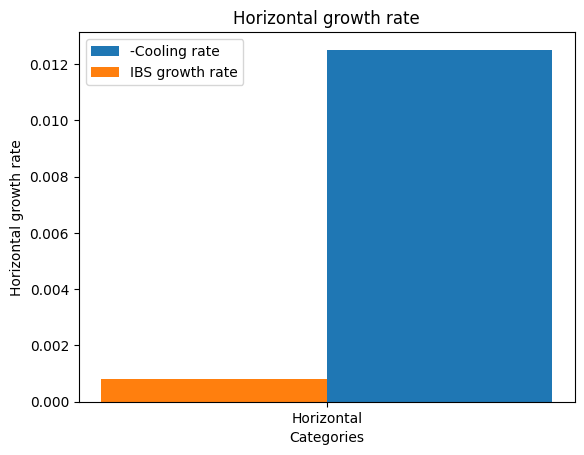

<Figure size 640x480 with 0 Axes>

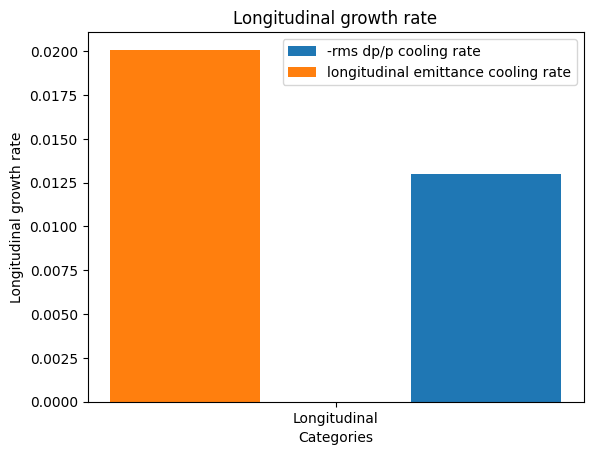

In [155]:
# Width of a bar
bar_width = 0.35

plt.figure()
# Create bars
plt.bar([pos + bar_width/2 for pos in range(1)], -transverse_cooling_rate, bar_width, label='-Cooling rate')
plt.bar([pos - bar_width/2 for pos in range(1)], growth_rate_x, bar_width, label='IBS growth rate')


# Add labels, title, and legend
plt.xlabel('Categories')
plt.ylabel('Horizontal growth rate')
plt.title('Horizontal growth rate')
plt.xticks(range(1), ['Horizontal'])  # single category label
plt.legend()

# Show the plot
plt.show()


plt.figure()
plt.figure()

# Create bars
plt.bar([0 + bar_width], -longitudinal_growth_rate, bar_width, label='-rms dp/p cooling rate')
# plt.bar([0], growth_rate_z, bar_width, label='IBS growth rate')
plt.bar([0 - bar_width], -longitudinal_emittance_growth_rate, bar_width, label='longitudinal emittance cooling rate')

# Add labels, title, and legend
plt.xlabel('Categories')
plt.ylabel('Longitudinal growth rate')
plt.title('Longitudinal growth rate')
plt.xticks([0], ['Longitudinal'])  # single category label
plt.legend()
plt.show()